In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.load('img_data.npz')['a']

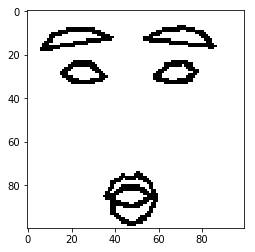

In [3]:
plt.imshow(data[0][0], cmap = 'Greys')
plt.show()

In [4]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Dropout, Activation
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import defaultdict

/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
input_shape = (100, 100,1)
left_input = Input(input_shape, name = 'left')
right_input = Input(input_shape, name = 'right')

convnet = Sequential()
convnet.add(Conv2D(32, kernel_size = (3,3)))
convnet.add(Activation('relu'))
convnet.add(MaxPooling2D(pool_size = (2,2)))


convnet.add(Flatten())
convnet.add(Dense(50,activation="relu"))

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(lr = 0.005)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

3842021

In [6]:
def getBatch50Percent(data, n):
    batch = np.zeros(shape = (n,2, 100, 100, 1))
    targets = np.zeros(shape = (n, 1))
    for i in range(0, n):
        same = np.random.randint(0,2)
        if(same):
            randExpression = np.random.choice(len(data[0]), 1)
            randPerson1 = np.random.choice(len(data), 1)
            randPerson2 = np.random.choice(len(data), 1)
            batch[i][0] = data[randPerson1,randExpression].reshape(100, 100, 1)
            batch[i][1] = data[randPerson1, randExpression].reshape(100, 100, 1)
            targets[i] = [1]
        else:
            exs = np.arange(0, len(data[0]))
            randExpression1 = np.random.choice(exs, 1)
            exs = np.delete(exs, randExpression1)
            randExpression2 = np.random.choice(exs, 1)
            randPerson1 = np.random.choice(len(data), 1)
            randPerson2 = np.random.choice(len(data), 1)
            batch[i][0] = data[randPerson1,randExpression1].reshape(100, 100, 1)
            batch[i][1] = data[randPerson1,randExpression2].reshape(100, 100, 1)
            targets[i] = [0]
    return (batch, targets)

In [7]:
def train50Percent(data, network, epochs, batch_size):
    track_loss  = defaultdict(list)
    for i in range(0, epochs):
        mini_batch, targets = getBatch50Percent(data, batch_size)
        loss=siamese_net.train_on_batch(
        {
         'left': mini_batch[:,0],
         'right': mini_batch[:,1],
        },targets)
        track_loss['Epoch%s'%(i)].append(loss)
        print('Epoch%s-----AVGLoss: %f' %(i + 1, loss))
    return network, track_loss

siamese_net, track_loss = train50Percent(data,siamese_net, 200, 10)

Epoch1-----AVGLoss: 0.657620
Epoch2-----AVGLoss: 0.346067
Epoch3-----AVGLoss: 0.206604
Epoch4-----AVGLoss: 0.549245
Epoch5-----AVGLoss: 0.273752
Epoch6-----AVGLoss: 0.341077
Epoch7-----AVGLoss: 0.203965
Epoch8-----AVGLoss: 0.338829
Epoch9-----AVGLoss: 0.270154
Epoch10-----AVGLoss: 0.403868
Epoch11-----AVGLoss: 0.335393
Epoch12-----AVGLoss: 0.401064
Epoch13-----AVGLoss: 0.333029
Epoch14-----AVGLoss: 0.199103
Epoch15-----AVGLoss: 0.330681
Epoch16-----AVGLoss: 0.329519
Epoch17-----AVGLoss: 0.328352
Epoch18-----AVGLoss: 0.261746
Epoch19-----AVGLoss: 0.391233
Epoch20-----AVGLoss: 0.389825
Epoch21-----AVGLoss: 0.323667
Epoch22-----AVGLoss: 0.451476
Epoch23-----AVGLoss: 0.257021
Epoch24-----AVGLoss: 0.576167
Epoch25-----AVGLoss: 0.318869
Epoch26-----AVGLoss: 0.381190
Epoch27-----AVGLoss: 0.253156
Epoch28-----AVGLoss: 0.378315
Epoch29-----AVGLoss: 0.251260
Epoch30-----AVGLoss: 0.187750
Epoch31-----AVGLoss: 0.249440
Epoch32-----AVGLoss: 0.124282
Epoch33-----AVGLoss: 0.123866
Epoch34-----AVGLoss

In [8]:
test_data = np.load('test_img_data.npz')['a']

In [9]:
test_data.shape

(1, 7, 100, 100)

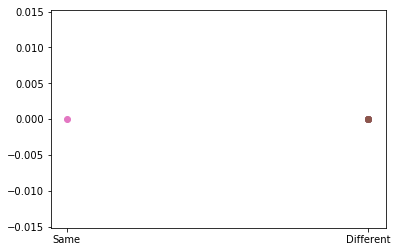

In [10]:
def plotEvalSet(test, actual_data):
    x = np.arange(0, 2)
    confusion = np.zeros(shape = (2,2))
    """
    Confusion Mat:  [True Positive, False Negative]
                    [False Positive, True Negative]
    """
    for i in range(len(test[0])):
        person1 = test[0][i]
        randExpression = np.random.randint(len(actual_data[0]))
        person2 = actual_data[np.random.randint(len(actual_data)),
                              randExpression]
        same = False
        if(i == randExpression):
            same = True

        out = siamese_net.predict({'left': person1.reshape(1, 100, 100, 1),
                                    'right': person2.reshape(1, 100, 100, 1)
                                    })
        if(same):
            if(out > 0.5):
                confusion[0,0] +=1
            else:
                confusion[0,1] += 1
            plt.scatter(0, out[0][0])
        else:
            if(out < 0.5):
                confusion[1,1] +=1
            else:
                confusion[1,0] += 1
            plt.scatter(1, out[0][0])
    plt.xticks(x, ['Same', 'Different'])
    plt.show()
    return confusion

confusion_mat = plotEvalSet(test_data, data)

In [11]:
print(confusion_mat)

[[0. 1.]
 [0. 6.]]


In [12]:
siamese_net.save_weights('siamese_conv_trained.h5')